# MSCI 598: Custom Project
## Medical Abstract Classification


In [1]:
import pandas as pd
import numpy as np 
import math
import os
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

torch.manual_seed(1)

In [2]:
destination_folder = "D:/med_abstracts/models"

ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(torch.cuda.is_available() )
print(device)

True
cuda:0


In [3]:
# SOURCE for preprocessing functions: 
# Abstract Segmentation NLP notebook (https://www.kaggle.com/anshulmehtakaggl/abstract-segmentation-nlp)

# Creating a function to read the txt Files
# This function returns all the lines in the txt file as a list
def get_lines(filename):
    with open(filename,"r") as f:
        return f.readlines()

# Creating a function to read the txt Files
# This function returns all the lines in the txt file as a list
def get_lines(filename):
    with open(filename,"r") as f:
        return f.readlines()

#Preprocessing Functions
# Returns a list of dictionaries of abstract's lines
# Dict Format --> {'TARGET':'Background/Results/Objetive/Concludion','Text':'The actual statement'}
def preprocess_data(filename):
    input_lines=get_lines(filename)
    #This will be used to separte the abstracts from  one another using String mets
    abstract_lines=""
    # Empty list of abstracts        
    abstract_samples=[]
    for line in input_lines:
        # Check for a new abstract
        if line.startswith("###"):
            abstract_id=line
            # And since we are in a new abstract we will Reset the abstract_lines
            abstract_lines=""
        # Check for a new line \n escape seq
        elif line.isspace():
            # Split the Lines of the abstract and will return a list of one abstract
            abstract_line_split=abstract_lines.splitlines()
            # Now we have to iterate through this singular abstract
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                #  Enumerate() method adds a counter to an iterable and returns it in a form of enumerating object.
                # Create a empty Dict per line
                line_data={}
                # Split on the tab \t esc seq
                target_text_split=abstract_line.split("\t")
                # Get the Label of the sentence as the Label
                line_data["target"]=target_text_split[0]
                # Get the Text of the Lien as the Text Key
                line_data["text"]=target_text_split[1].lower()
                # Also adding the Line Nnumber as it will also aid the model
                line_data["line_number"]=abstract_line_number
                # Number of Lines in that particular abstract
                line_data["total_lines"]=len(abstract_line_split)-1
                # Now we have to append them to the absract_samples list
                abstract_samples.append(line_data)
        # So if both the cases are not there then the line is a labelled sentence
        else:
            abstract_lines+=line
    return abstract_samples


In [4]:
# Reading in and preprocessing data
data_dir = "D:/med_abstracts/20k_abstracts_numbers_with_@/"
filenames=[data_dir + filename for filename in os.listdir(data_dir)]
print(filenames)

train_samples=preprocess_data(data_dir+"train.txt")
val_samples=preprocess_data(data_dir+"dev.txt")
test_samples=preprocess_data(data_dir+"test.txt")        


['D:/med_abstracts/20k_abstracts_numbers_with_@/dev.txt', 'D:/med_abstracts/20k_abstracts_numbers_with_@/test.txt', 'D:/med_abstracts/20k_abstracts_numbers_with_@/train.txt']


In [5]:
# Converting data to df
train_df=pd.DataFrame(train_samples)
test_df=pd.DataFrame(test_samples)
val_df=pd.DataFrame(val_samples)

# Data distribution
train_df.target.value_counts()

# Isolating the sentences
train_sentences=train_df["text"].tolist()
test_sentences=test_df["text"].tolist()
val_sentences=val_df["text"].tolist()

In [6]:
# Turning the target Labels into Numeric Data
# We have 5 main labels -> Background, Objective,Methods, Results, Conclusion
# We'll encode them both 1HEC and Simple Numerical

# Tensorflow is incompatible with sparse matrices
one_hot_encoder=OneHotEncoder(sparse=False)
# You should reshape your X to be a 2D array not 1D array. Fitting a model requires requires a 2D array. i.e (n_samples, n_features)
train_labels_one_hot=one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot=one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot=one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))
train_labels_one_hot,val_labels_one_hot,test_labels_one_hot

le=LabelEncoder()
train_labels_encoded=le.fit_transform(train_df["target"])
test_labels_encoded=le.fit_transform(test_df["target"])
val_labels_encoded=le.fit_transform(val_df["target"])

train_labels_onehot = nn.functional.one_hot(torch.from_numpy(train_labels_encoded).to(torch.int64), num_classes=- 1)
val_labels_onehot = nn.functional.one_hot(torch.from_numpy(val_labels_encoded).to(torch.int64), num_classes=- 1)
test_labels_onehot = nn.functional.one_hot(torch.from_numpy(test_labels_encoded).to(torch.int64), num_classes=- 1)


# Retieving classes 
num_classes=len(le.classes_)
class_names=le.classes_
num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [7]:
# Vectorize the text and then create Embeddings

# How long is each sentence on average
sent_lens=[len(sentence.split()) for sentence in train_sentences]
avg_sent_lens=np.mean(sent_lens)
avg_sent_lens
# sent_lens
#  So we will need Padding and Truncating as the input shapes must be maintained

# Calculate the percentile of length of sentences
output_seq_len=int(np.percentile(sent_lens,95))
output_seq_len
# So 95% sentences are in length of 55

# Creating a text Vectorization Layer
# Mapping our text from words to Numbers
# An embedding is a relatively low-dimensional space into which you can translate high-dimensional vectors. 
# Vocabulary size in the Research Paper is 68000
max_tokens=68000

text_vectorizer=TextVectorization(max_tokens=max_tokens,output_sequence_length=output_seq_len)

# Adapt the Text Vectorizer to the Training Data
# We have to adapt it to only the training data so that val and test data are not seen
# Later it can be fitted to the two latter
text_vectorizer.adapt(train_sentences)

In [8]:
# Finding out how many words are there  in the training vocabulary and which are  most common
# Also text vectorizer works pretty straightforwardly, 1 to most common word, 2 to 2nd most common word and so on
train_vocab=text_vectorizer.get_vocabulary()
# Size of Vocab
print(len(train_vocab))
# 5 Most Common Words in the Vocab
print(train_vocab[:5])
# Least common 5 words in the vocab
print(train_vocab[-5:])

# Get the config of our Text Vectorizer
text_vectorizer.get_config()

64841
['', '[UNK]', 'the', 'and', 'of']
['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [9]:
# Create an Embedding Layer
# More output dims , more emmbedding, more parameters to train
# Masking the 0 considering them as padding
    
#token_embed=layers.Embedding(input_dim=len(train_vocab),output_dim=128,mask_zero=True,name="token_embedding")

token_embed_py = torch.nn.Embedding(num_embeddings=len(train_vocab), embedding_dim=128, padding_idx=0)


In [10]:
# Dataset class for vectorized sentences
class CustomTextDataset(Dataset):
    def __init__(self, data, labels):
        self.labels = labels
        self.data = data

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.labels[idx]
        return data, label

train_dataset = CustomTextDataset(train_sentences, train_labels_one_hot)
val_dataset = CustomTextDataset(val_sentences, val_labels_one_hot)
test_dataset = CustomTextDataset(test_sentences, test_labels_one_hot)

train_loader = DataLoader(train_dataset, batch_size=28, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=28, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=28, shuffle=True)

# <TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>
# Which indicates one Text Sample in first tuple, next tuple is (0,0,0,0,1) -> 1hc 

# LSTM
https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0

In [11]:
# This is the model structure used for the abstract classification, with an output of 5
class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(train_vocab), 300, padding_idx=0)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=2,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 5)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        #packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_input = text_emb
        packed_output, _ = self.lstm(packed_input)
        #output, _ = pad_packed_sequence(packed_output, batch_first=True)
        output = packed_output
        
        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

# This is the model structure used for pre-training on sentiment classification, with an output of 2
class LSTM_binary(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM_binary, self).__init__()

        self.embedding = nn.Embedding(len(train_vocab), 300, padding_idx=0)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=2,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 2)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        #packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_input = text_emb
        packed_output, _ = self.lstm(packed_input)
        #output, _ = pad_packed_sequence(packed_output, batch_first=True)
        output = packed_output
        
        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

In [12]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [23]:
destination_folder = "D:/med_abstracts/models"

# Training Function

def train(model,
          optimizer,
          scheduler,
          criterion = nn.BCELoss(),
          train_loader = train_loader,
          valid_loader = val_loader,
          num_epochs = 5,
          eval_every = len(train_loader) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for data, labels in train_loader:   
            data = text_vectorizer(data).numpy()
            data, labels = torch.tensor(data).to(device), torch.tensor(labels).to(device)

            output = model(data, output_seq_len)

            loss = criterion(output, labels.to(torch.float32))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            
            # update running values
            running_loss += loss.item()
            global_step += 1

            
            
            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for data, labels in valid_loader:
                        data = text_vectorizer(data).numpy()
                        data, labels = torch.tensor(data).to(device), torch.tensor(labels).to(device)
                        output = model(data, output_seq_len)

                        loss = criterion(output, labels.to(torch.float32))
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')
    

num_epochs = 5
model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

train(model=model, optimizer=optimizer, scheduler=scheduler, num_epochs=num_epochs)

<ipython-input-23-d65fe6bdea8d>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, labels = torch.tensor(data).to(device), torch.tensor(labels).to(device)
<ipython-input-23-d65fe6bdea8d>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, labels = torch.tensor(data).to(device), torch.tensor(labels).to(device)


Epoch [1/5], Step [3215/32150], Train Loss: 0.2342, Valid Loss: 0.1845
Model saved to ==> D:/med_abstracts/models/model.pt
Model saved to ==> D:/med_abstracts/models/metrics.pt
Epoch [1/5], Step [6430/32150], Train Loss: 0.1863, Valid Loss: 0.1695
Model saved to ==> D:/med_abstracts/models/model.pt
Model saved to ==> D:/med_abstracts/models/metrics.pt
Epoch [2/5], Step [9645/32150], Train Loss: 0.1588, Valid Loss: 0.1664
Model saved to ==> D:/med_abstracts/models/model.pt
Model saved to ==> D:/med_abstracts/models/metrics.pt
Epoch [2/5], Step [12860/32150], Train Loss: 0.1581, Valid Loss: 0.1639
Model saved to ==> D:/med_abstracts/models/model.pt
Model saved to ==> D:/med_abstracts/models/metrics.pt
Epoch [3/5], Step [16075/32150], Train Loss: 0.1313, Valid Loss: 0.1695
Epoch [3/5], Step [19290/32150], Train Loss: 0.1334, Valid Loss: 0.1676
Epoch [4/5], Step [22505/32150], Train Loss: 0.1058, Valid Loss: 0.1787
Epoch [4/5], Step [25720/32150], Train Loss: 0.1113, Valid Loss: 0.1799
Epo

Model loaded from <== D:/med_abstracts/models/metrics.pt


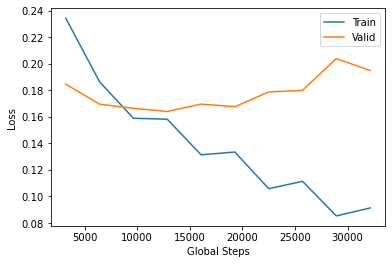

In [24]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [25]:
# Evaluation Function
word_labels = np.unique(train_df["target"])
word_labels_short = [word_labels[i][:4] for i in np.arange(len(word_labels))]

def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for data, labels in test_loader:
            data = text_vectorizer(data).numpy()
            data, labels = torch.tensor(data).to(device), torch.tensor(labels).to(device)
            output = model(data, output_seq_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[0,1,2,3,4], target_names=word_labels, digits=4))
    
    cm = confusion_matrix(np.array(y_true).argmax(axis=1), np.array(y_pred).argmax(axis=1), labels=[0,1,2,3,4], normalize='true')
    print(cm)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues')

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(word_labels_short)
    ax.yaxis.set_ticklabels(word_labels_short)
    

Model loaded from <== D:/med_abstracts/models/model.pt


<ipython-input-25-77f9d46e20a3>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, labels = torch.tensor(data).to(device), torch.tensor(labels).to(device)


Classification Report:
              precision    recall  f1-score   support

  BACKGROUND     0.6653    0.6686    0.6669      3621
 CONCLUSIONS     0.7974    0.6966    0.7436      4571
     METHODS     0.9005    0.9014    0.9009      9897
   OBJECTIVE     0.8213    0.4453    0.5775      2333
     RESULTS     0.8898    0.8749    0.8823      9713

   micro avg     0.8487    0.7985    0.8228     30135
   macro avg     0.8149    0.7174    0.7543     30135
weighted avg     0.8470    0.7985    0.8179     30135
 samples avg     0.7977    0.7985    0.7980     30135

[[8.06407070e-01 8.00883734e-02 5.08146921e-02 5.60618614e-02
  6.62800331e-03]
 [1.78954277e-01 6.96346532e-01 1.77204113e-02 4.37541019e-04
  1.06541238e-01]
 [4.19318986e-02 3.73850662e-03 9.01384258e-01 1.51561079e-03
  5.14297262e-02]
 [4.55636520e-01 3.85769396e-02 5.65795114e-02 4.43634805e-01
  5.57222460e-03]
 [2.58416555e-02 4.03582827e-02 6.06403789e-02 2.05909606e-04
  8.72953773e-01]]


C:\Users\Tia\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


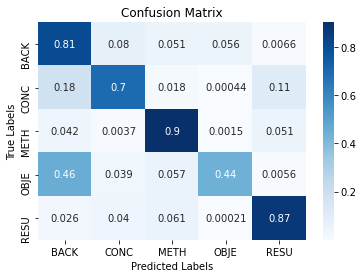

In [26]:
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
evaluate(best_model, test_loader)

In [27]:
l = [module for module in model.modules() if not isinstance(module, nn.Sequential)]
print(l)

[LSTM(
  (embedding): Embedding(64841, 300, padding_idx=0)
  (lstm): LSTM(300, 128, batch_first=True, bidirectional=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
), Embedding(64841, 300, padding_idx=0), LSTM(300, 128, batch_first=True, bidirectional=True), Dropout(p=0.5, inplace=False), Linear(in_features=256, out_features=5, bias=True)]


In [30]:
from torchviz import make_dot
data, labels = next(iter(train_loader))
yhat = model(torch.tensor(text_vectorizer(data).numpy()).to(device), output_seq_len) # Give dummy batch to forward().
make_dot(yhat, params=dict(list(model.named_parameters()))).render("lstm_torchviz", format="png")

'lstm_torchviz.png'

# Transfer Learning

In [20]:
dimension=128
num_epochs=5

model = LSTM_binary().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/Model_cos_10_epochs_PRETRAINED/model.pt', model, optimizer)
#evaluate(best_model, test_loader)

num_epochs = 5
#model = LSTM().to(device)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

# Freeze layers
for param in model.parameters():
    param.requires_grad = False
    
# Replace the last fully-connected layer
# Parameters of newly constructed modules have requires_grad=True by default
model.fc = nn.Linear(2*dimension, 5) # assuming that the fc7 layer has 512 neurons, otherwise change it 
model.fc.requires_grad = True
#model.embedding = nn.Embedding(len(train_vocab), 300, padding_idx=0)
model.cuda()


Model loaded from <== D:/med_abstracts/models/Model_cos_10_epochs_PRETRAINED/model.pt


LSTM_binary(
  (embedding): Embedding(64841, 300, padding_idx=0)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, bidirectional=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)

In [21]:
train(model=model, optimizer=optimizer, scheduler=scheduler, num_epochs=num_epochs)

<ipython-input-13-d65fe6bdea8d>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, labels = torch.tensor(data).to(device), torch.tensor(labels).to(device)
<ipython-input-13-d65fe6bdea8d>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, labels = torch.tensor(data).to(device), torch.tensor(labels).to(device)


Epoch [1/5], Step [3215/32150], Train Loss: 0.6984, Valid Loss: 0.6964
Model saved to ==> D:/med_abstracts/models/model.pt
Model saved to ==> D:/med_abstracts/models/metrics.pt
Epoch [1/5], Step [6430/32150], Train Loss: 0.6983, Valid Loss: 0.6964
Epoch [2/5], Step [9645/32150], Train Loss: 0.6985, Valid Loss: 0.6964
Epoch [2/5], Step [12860/32150], Train Loss: 0.6983, Valid Loss: 0.6964
Epoch [3/5], Step [16075/32150], Train Loss: 0.6984, Valid Loss: 0.6964
Epoch [3/5], Step [19290/32150], Train Loss: 0.6984, Valid Loss: 0.6964
Epoch [4/5], Step [22505/32150], Train Loss: 0.6986, Valid Loss: 0.6964
Epoch [4/5], Step [25720/32150], Train Loss: 0.6984, Valid Loss: 0.6964
Epoch [5/5], Step [28935/32150], Train Loss: 0.6985, Valid Loss: 0.6964
Epoch [5/5], Step [32150/32150], Train Loss: 0.6984, Valid Loss: 0.6964
Model saved to ==> D:/med_abstracts/models/model.pt
Model saved to ==> D:/med_abstracts/models/metrics.pt
Model saved to ==> D:/med_abstracts/models/metrics.pt
Finished Training

<ipython-input-18-77f9d46e20a3>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, labels = torch.tensor(data).to(device), torch.tensor(labels).to(device)


Classification Report:
              precision    recall  f1-score   support

  BACKGROUND     0.1297    0.5568    0.2104      3621
 CONCLUSIONS     0.1537    0.6519    0.2488      4571
     METHODS     0.3296    0.5289    0.4061      9897
   OBJECTIVE     0.0729    0.4226    0.1243      2333
     RESULTS     0.3077    0.4481    0.3648      9713

   micro avg     0.1984    0.5166    0.2867     30135
   macro avg     0.1987    0.5217    0.2709     30135
weighted avg     0.2520    0.5166    0.3236     30135
 samples avg     0.1917    0.5166    0.2699     30135

[[0.57912179 0.29964098 0.07760287 0.02927368 0.01436067]
 [0.56136513 0.31284183 0.07350689 0.03106541 0.02122074]
 [0.54521572 0.31494392 0.08376276 0.03809235 0.01798525]
 [0.55979426 0.35490784 0.04629233 0.0235748  0.01543078]
 [0.51147946 0.34335427 0.08823227 0.03901987 0.01791414]]


C:\Users\Tia\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


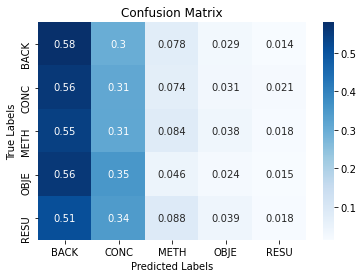

In [22]:
evaluate(model, test_loader)